## Initialization

**NGC 6656**

In [1]:
import os
import grasp
import numpy as np
import pandas as pd
from astropy import units as u
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
plt.ion()

dr3 = grasp.dr3()
gc = grasp.Cluster('NGC6656')
f = grasp.load_base_formulary()

gplt = grasp.plots
stats = grasp.stats

scan_radius = gc.rt.value*1.2

gc.rt_pc = gc.dist.to(u.pc) * np.tan(gc.rt.to(u.rad))



            ..............
         ..:;;..:;;;;;:::::;;
       ;;;;;;::.::;;;;;;;;;;;;;
      ;;;;.:;;;..;XXXXXX.::....:           GAIA QUERY MODULE
     :;::;::..+XXXXXXXXX+:;;;;;;:
    ;::;:.:;;:XXXXXXXXXXX::::::::;        __ _  __ _(_) __ _
    .;;..;;;:.:XXXXXXXXX$$$$$$$$$$X.     / _` |/ _` | |/ _` |
    :;..:;;;..:xXXXXXXX$$$$$$$$$$$$X    | (_| | (_| | | (_| |
    :;:.:;;.XXXXXXXXX$$$$$$$$$$$$$$;     \__, |\__,_|_|\__,_|
    .;;:.:X$$$$$$$$$$$$$$$$$$$$$$X.      |___/
    ..:;:$$$$$$$$$$$$$$$$$$$$$$X;.
     :;;;$$$$$$$$$$$$$$$$$$$$::;;             INITIALIZED
      ...;$$$$$$$$$$$$$$x;:;;;;;
        ......:;:....;;;;;;;:.
          ::::::::::;;;::...
            ....::::.....

Initialized with Gaia table: 'gaiadr3.gaia_source'


In [2]:
print(gc)


Harris Catalog 2010 edition Parameters

       Key                  Value
----------------------------------------
.id      Cluster Name       NGC6656
.ra      Position in sky    RA  279.10 deg
.dec                        DEC -23.90 deg
.dist    Distance           3.20 kpc
.w0      W0 Parameter       6.48
.logc    Concentration      logc=1.38
.cflag                      Collapsed -> False
.rc      Core radius        0.022 deg
.rh      Half-Light radius  0.056 deg
.rt      Tidal Radius       0.532 deg



In [3]:
fas = dr3.get_astrometry(
    radius=scan_radius, 
    gc=gc, 
    save=True, 
    add_data="ra_dec_corr, pmra_pmdec_corr, phot_g_mean_mag, nu_eff_used_in_astrometry, pseudocolour, ecl_lat, astrometric_params_solved",
    conditions='astrometric_params_solved != 3',)

fas.info()


Found data with the same conditions for object NGC6656 in
20250602_002609.
Loading it...
Sample number of sources: 651815
<Sample length=651815>
           name            dtype    unit                                        description                                          class      n_bad 
------------------------- ------- -------- ------------------------------------------------------------------------------------- -------------- ------
                SOURCE_ID   int64                             Unique source identifier (unique within a particular Data Release)   MaskedColumn      0
                       ra float64      deg                                                                       Right ascension MaskedQuantity      0
                 ra_error float32      mas                                                     Standard error of right ascension MaskedQuantity      0
                      dec float64      deg                                                          

In [4]:
Nneg = len(fas.to_pandas()[fas['parallax']<0])

grasp.zero_point_correction(sample=fas)

Nneg_f = len(fas.to_pandas()[fas['parallax']<0])

print(f"Saved stars from negative parallax: {Nneg-Nneg_f} ({(1-Nneg_f/Nneg)*100:.2f}%)")

Using the "Zero Point Correction" tool from Pau Ramos
(Lindergren, et al., A&A 649, A4 (2021)

Saved stars from negative parallax: 7524 (3.76%)


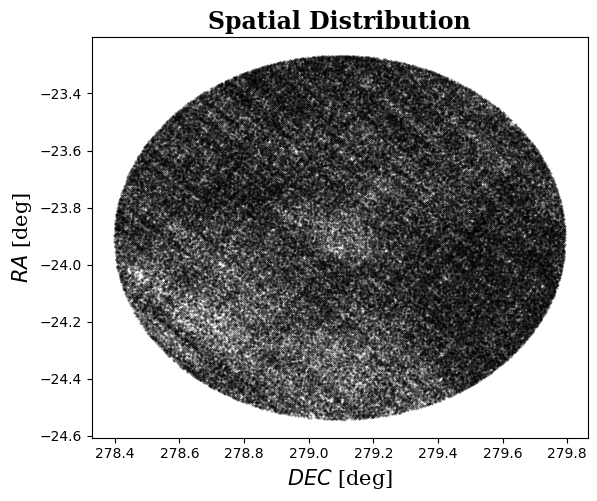

(<Figure size 640x520 with 1 Axes>,
 <Axes: title={'center': 'Spatial Distribution'}, xlabel='$DEC$ [deg]', ylabel='$RA$ [deg]'>)

In [115]:
gplt.spatial(fas, size=0.1, alpha=0.55, axis=None)

## GMM on Full Sample

### Feature Engeneering

In [6]:
useless_columns = ["phot_g_mean_mag,nu_eff_used_in_astrometry,pseudocolour,ecl_lat,astrometric_params_solved"]
for c in useless_columns:
    if c in fas.columns:
        fas.drop_column(c)
fas.dropna()

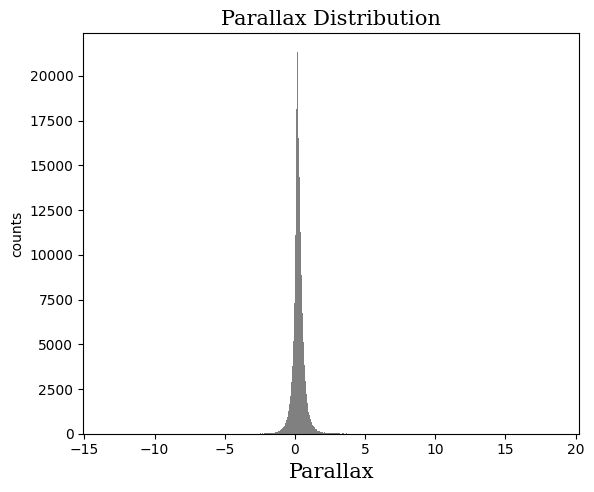

In [7]:
gplt.histogram(fas.parallax.value, xlabel='Parallax')

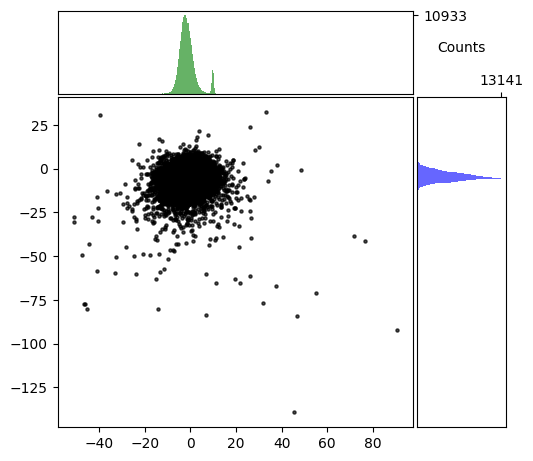

(<Figure size 560x520 with 3 Axes>,
 (<Axes: >, <Axes: >, <Axes: xlabel='Counts\n'>))

In [8]:
gplt.doubleHistScatter(fas.pmra.value, fas.pmdec.value)

Removing poroper motion extreme outliers and creating a copy sample with only positive parallaxes

In [9]:
fas.apply_conditions(
    conditions={
        "pmra": ">-50",
        "pmdec":">-50",
    },
    inplace=True,
)
fas.apply_conditions(
    conditions={
        "pmra": "<50",
        "pmdec":"<50",
    },
    inplace=True,
)
pfas = fas.apply_conditions(
    conditions={
        'parallax': ">0"
    },
    inplace=False,
)

Cut 0.016% of the sample
Cut 0.001% of the sample


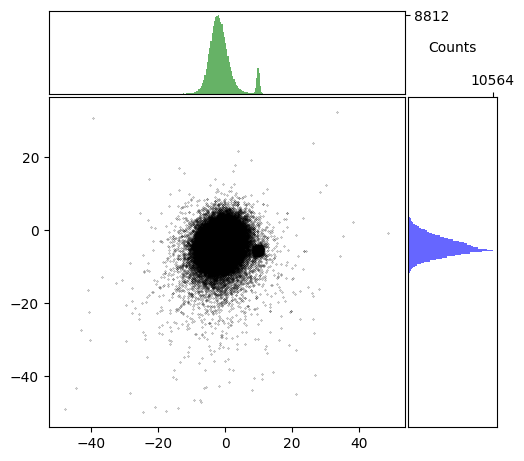

(<Figure size 560x520 with 3 Axes>,
 (<Axes: >, <Axes: >, <Axes: xlabel='Counts\n'>))

In [10]:
grasp.plots.doubleHistScatter(fas.pmra.value, fas.pmdec.value, size=0.05, alpha=0.85)

In [11]:
data = fas[['ra','dec','pmra','pmdec', 'parallax']].to_numpy()
pdata = pfas[['ra','dec','pmra','pmdec', 'parallax']].to_numpy()

### Single GMM

#### Model1: GMM with  $\,\forall \bar{\omega} \in \mathcal{R}$

```python

X_train, X_test = train_test_split(data, test_size=0.33)

model1 = grasp.stats.gaussian_mixture_model(train_data=X_train, G=3, modelNames=np.array(['VII', 'VVI']), verbose=True)

plt.figure()
plt.scatter(X_train[:,2], X_train[:,3], c=model1.train_classification['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(model1.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(model1.train_classification['classification'])])
plt.title('Model1: G=3 with full parallaxes')

pd.DataFrame(data=model1.train_classification['classification']).value_counts()

model1_parameters = pd.DataFrame(data=model1.coeffs, index=['G1','G2','G3'], columns=['ra','dec','pmra','pmdec','parallax'])

print(model1_parameters)

predictions = model1.predict(X_test)

plt.figure()
plt.scatter(X_test[:,2], X_test[:,3], c=predictions['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(predictions['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(predictions['classification'])])
plt.title('Model1 Test Set')
plt.show()
```

#### Model2: GMM with $\,\forall\bar{\omega}\in\mathcal{R}^+$

```python
X_train2, X_test2 = train_test_split(pdata, test_size=0.33)
model2 = grasp.stats.gaussian_mixture_model(train_data=X_train2, G=3, modelNames=np.array(['VII', 'VVI']), verbose=True)

plt.figure()
plt.scatter(X_train2[:,2], X_train2[:,3], c=model2.train_classification['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(model2.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(model2.train_classification['classification'])])
plt.title('Model2: G=3 with parallax cut')

pd.DataFrame(data=model2.train_classification['classification']).value_counts()
model2_parameters = pd.DataFrame(data=model2.coeffs, index=['G1','G2','G3'], columns=['ra','dec','pmra','pmdec','parallax'])
print(model2_parameters)
predictions2 = model2.predict(X_test2)

plt.figure()
plt.scatter(X_test2[:,2], X_test2[:,3], c=predictions2['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(predictions2['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(predictions2['classification'])])
plt.title('Model2 Test Set')
```

#### Model3: $G=2$ with $\forall\bar{\omega}\in\mathcal{R}^+$

```python
X_train2, X_test2 = train_test_split(pdata, test_size=0.33)
model3 = grasp.stats.gaussian_mixture_model(train_data=X_train2, G=2, modelNames=np.array(['VII', 'VVI']), verbose=True)


plt.figure()
plt.scatter(X_train2[:,2], X_train2[:,3], c=model3.train_classification['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(model3.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(model3.train_classification['classification'])])
plt.title('Model3: G=2 with parallax cut')

pd.DataFrame(data=model3.train_classification['classification']).value_counts()
predictions3 = model3.predict(X_test2)
model3_parameters = pd.DataFrame(data=model3.coeffs, index=['G1','G2'], columns=['ra','dec','pmra','pmdec','parallax'])
print(model3_parameters)

plt.figure()
plt.scatter(X_test2[:,2], X_test2[:,3], c=predictions3['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(predictions3['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(predictions3['classification'])])
plt.title('Model3 Test Set')
```

#### Model4: $G=2$ with $\forall\bar{\omega}\in\mathcal{R}$

```python
X_train, X_test = train_test_split(data, test_size=0.33)
model4 = grasp.stats.gaussian_mixture_model(train_data=X_train, G=2, modelNames=np.array(['VII', 'VVI']), verbose=True)

plt.figure()
plt.scatter(X_train[:,2], X_train[:,3], c=model4.train_classification['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(model4.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(model4.train_classification['classification'])])
plt.title('Model3: G=2 with parallax cut')

pd.DataFrame(data=model4.train_classification['classification']).value_counts()
predictions4 = model4.predict(X_test)
model4_parameters = pd.DataFrame(data=model4.coeffs, index=['G1','G2'], columns=['ra','dec','pmra','pmdec','parallax'])
print(model4_parameters)

plt.figure()
plt.scatter(X_test[:,2], X_test[:,3], c=predictions4['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(predictions4['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(predictions4['classification'])])
plt.title('Model3 Test Set')
plt.show()
```

### KFold Cross-Validation with GMM

#### G=3  -  $\forall\bar{\omega}\in\mathcal{R}^+$ 

In [12]:
nfolds = 20
kfm_3pos = grasp.stats.kfold_gmm_estimator(
    data=pdata,
    folds=nfolds,
    G=3,
    modelNames=np.array(['VII', 'VVI']),
    verbose=False
)

Correctly imported `mclust`.
[1] "Fold 1"
[1] "Fold 2"
[1] "Fold 3"
[1] "Fold 4"
[1] "Fold 5"
[1] "Fold 6"
[1] "Fold 7"
[1] "Fold 8"
[1] "Fold 9"
[1] "Fold 10"
[1] "Fold 11"
[1] "Fold 12"
[1] "Fold 13"
[1] "Fold 14"
[1] "Fold 15"
[1] "Fold 16"
[1] "Fold 17"
[1] "Fold 18"
[1] "Fold 19"
[1] "Fold 20"


In [13]:
plt.plot(np.arange(1,nfolds+1), kfm_3pos.bics, '-o', label='Models BIC')
plt.plot([1,nfolds+1], [kfm_3pos.mean_bic,kfm_3pos.mean_bic], '--', label='Mean BIC')
plt.xticks(ticks=np.arange(1, nfolds + 2, 1))
plt.grid(True)
plt.title('BIC vs Number of folds')
plt.xlabel('Fold number')
plt.ylabel('BIC')
plt.legend(loc='best')

print(f"Model's BIC Variance: {(np.min(kfm_3pos.bics) - np.max(kfm_3pos.bics))/np.max(kfm_3pos.bics) * 100:.3f} %")

Model's BIC Variance: 4.823 %


#### G=2  -  $\forall\bar{\omega}\in\mathcal{R}^+$ 

In [14]:
nfolds = 20
kfm_2pos = grasp.stats.kfold_gmm_estimator(
    data=pdata,
    folds=nfolds,
    G=2,
    modelNames=np.array(['VII', 'VVI']),
    verbose=False
)

Correctly imported `mclust`.
[1] "Fold 1"
[1] "Fold 2"
[1] "Fold 3"
[1] "Fold 4"
[1] "Fold 5"
[1] "Fold 6"
[1] "Fold 7"
[1] "Fold 8"
[1] "Fold 9"
[1] "Fold 10"
[1] "Fold 11"
[1] "Fold 12"
[1] "Fold 13"
[1] "Fold 14"
[1] "Fold 15"
[1] "Fold 16"
[1] "Fold 17"
[1] "Fold 18"
[1] "Fold 19"
[1] "Fold 20"


In [15]:
plt.plot(np.arange(1,nfolds+1), kfm_2pos.bics, '-o', label='Models BIC')
plt.plot([1,nfolds+1], [kfm_2pos.mean_bic,kfm_2pos.mean_bic], '--', label='Mean BIC')
plt.xticks(ticks=np.arange(1, nfolds + 2, 1))
plt.grid(True)
plt.title('BIC vs Number of folds')
plt.xlabel('Fold number')
plt.ylabel('BIC')
plt.legend(loc='best')

print(f"Model's BIC Variance: {(np.min(kfm_2pos.bics) - np.max(kfm_2pos.bics))/np.max(kfm_2pos.bics) * 100:.3f} %")

Model's BIC Variance: 2.655 %


#### G=3  -  $\forall\bar{\omega}\in\mathcal{R}$

In [16]:
nfolds = 20
kfm_3 = grasp.stats.kfold_gmm_estimator(
    data=data,
    folds=nfolds,
    G=3,
    modelNames=np.array(['VII', 'VVI']),
    verbose=False
)

Correctly imported `mclust`.
[1] "Fold 1"
[1] "Fold 2"
[1] "Fold 3"
[1] "Fold 4"
[1] "Fold 5"
[1] "Fold 6"
[1] "Fold 7"
[1] "Fold 8"
[1] "Fold 9"
[1] "Fold 10"
[1] "Fold 11"
[1] "Fold 12"
[1] "Fold 13"
[1] "Fold 14"
[1] "Fold 15"
[1] "Fold 16"
[1] "Fold 17"
[1] "Fold 18"
[1] "Fold 19"
[1] "Fold 20"


In [17]:
plt.plot(np.arange(1,nfolds+1), kfm_3.bics, '-o', label='Models BIC')
plt.plot([1,nfolds+1], [kfm_3.mean_bic,kfm_3.mean_bic], '--', label='Mean BIC')
plt.xticks(ticks=np.arange(1, nfolds + 2, 1))
plt.grid(True)
plt.title('BIC vs Number of folds')
plt.xlabel('Fold number')
plt.ylabel('BIC')
plt.legend(loc='best')

print(f"Model's BIC Variance: {(np.min(kfm_3.bics) - np.max(kfm_3.bics))/np.max(kfm_3.bics) * 100:.3f} %")

Model's BIC Variance: 3.922 %


#### G=2  -  $\forall\bar{\omega}\in\mathcal{R}$

In [18]:
nfolds = 20
kfm_2 = grasp.stats.kfold_gmm_estimator(
    data=data,
    folds=nfolds,
    G=2,
    modelNames=np.array(['VII', 'VVI']),
    verbose=False
)

Correctly imported `mclust`.
[1] "Fold 1"
[1] "Fold 2"
[1] "Fold 3"
[1] "Fold 4"
[1] "Fold 5"
[1] "Fold 6"
[1] "Fold 7"
[1] "Fold 8"
[1] "Fold 9"
[1] "Fold 10"
[1] "Fold 11"
[1] "Fold 12"
[1] "Fold 13"
[1] "Fold 14"
[1] "Fold 15"
[1] "Fold 16"
[1] "Fold 17"
[1] "Fold 18"
[1] "Fold 19"
[1] "Fold 20"


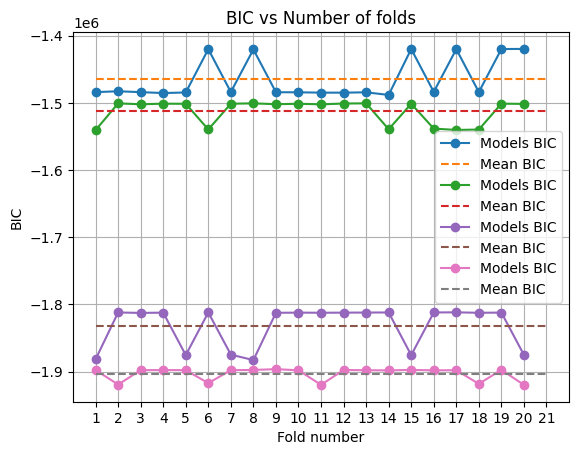

Model's BIC Variance: 1.236 %


In [19]:
plt.plot(np.arange(1,nfolds+1), kfm_2.bics, '-o', label='Models BIC')
plt.plot([1,nfolds+1], [kfm_2.mean_bic,kfm_2.mean_bic], '--', label='Mean BIC')
plt.xticks(ticks=np.arange(1, nfolds + 2, 1))
plt.grid(True)
plt.title('BIC vs Number of folds')
plt.xlabel('Fold number')
plt.ylabel('BIC')
plt.legend(loc='best')
plt.show()

print(f"Model's BIC Variance: {(np.min(kfm_2.bics) - np.max(kfm_2.bics))/np.max(kfm_2.bics) * 100:.3f} %")

#### Best Model Selection

In [20]:
best_models = {}
best_models['G=3 pos'] = kfm_3pos.best_model()
best_models['G=2 pos'] = kfm_2pos.best_model()
best_models['G=3'] = kfm_3.best_model()
best_models['G=2'] = kfm_2.best_model()


In [21]:
print(f"Best G=3 w>0 Model:\n {pd.DataFrame(best_models['G=3 pos'].coeffs, columns=['ra','dec','pmra','pmdec','parallax'])}\n")
print(f"Best G=2 w>0 Model:\n{pd.DataFrame(best_models['G=2 pos'].coeffs, columns=['ra','dec','pmra','pmdec','parallax'])}\n")
print(f"Best G=3 Model:\n{pd.DataFrame(best_models['G=3'].coeffs, columns=['ra','dec','pmra','pmdec','parallax'])}\n")
print(f"Best G=2 Model:\n{pd.DataFrame(best_models['G=2'].coeffs, columns=['ra','dec','pmra','pmdec','parallax'])}")

Best G=3 w>0 Model:
            ra        dec      pmra     pmdec  parallax
0  279.136944 -23.915760  2.206426 -4.919099  0.711827
1  279.145796 -24.038605 -2.046429 -4.484370  0.264651
2  279.067485 -23.529962 -1.940065 -4.374095  0.308990

Best G=2 w>0 Model:
           ra        dec      pmra     pmdec  parallax
0  279.123866 -23.875291 -1.819873 -4.480177  0.375257
1  279.107038 -23.903003  9.843992 -5.607625  0.335065

Best G=3 Model:
           ra        dec      pmra     pmdec  parallax
0  279.129146 -23.867128 -2.808838 -5.529581  0.168671
1  279.140719 -23.880172  2.026687 -5.585899  0.397473
2  279.119961 -23.876032 -0.497764 -2.409387  0.323149

Best G=2 Model:
           ra        dec      pmra     pmdec  parallax
0  279.130035 -23.870352 -1.886229 -4.597054  0.252518
1  279.107673 -23.903661  9.852581 -5.613833  0.301982


In [22]:
for key,value in best_models.items():
    best_models[key].save_model(grasp.gpaths.CLUSTER_DATA_FOLDER(gc.id)+f'/{key}')
    print(f"{key} model saved\n")

Model saved to /home/pietrof/graspdata/query/NGC6656/G=3 pos.rds
G=3 pos model saved

Model saved to /home/pietrof/graspdata/query/NGC6656/G=2 pos.rds
G=2 pos model saved

Model saved to /home/pietrof/graspdata/query/NGC6656/G=3.rds
G=3 model saved

Model saved to /home/pietrof/graspdata/query/NGC6656/G=2.rds
G=2 model saved



# Effective Potential Computation

### Loading the model and computing all the quantities

In [24]:
names = ['G=3 pos','G=2 pos','G=3','G=2']
best_models = {}
for n in names:
   best_models[n] =  grasp.GaussianMixtureModel.load_model(
    grasp.gpaths.CLUSTER_DATA_FOLDER(gc.id)+f'/{n}'
)

Utilizzando quaattro metodi diversi, si è calcolato il valore medio dei parametri per il cluster:

La media è stata calcolata con la formula classica, mentre l'uncertainty è stata stimata come $\epsilon = \dfrac{\sigma}{\sqrt{N}}$

$$ \langle\bar{\omega}\rangle = 0.550 \pm 0.002 \, \mathrm{mas} \rightarrow \sim 1.81 \,\mathrm{kpc}$$ 

$$ \langle\mu_\alpha\rangle = -12.528 \pm 0.003 \, \mathrm{mas\cdot yr}^{-1}$$

$$ \langle\mu_{\delta^*}\rangle = -19.022 \pm 0.005 \, \mathrm{mas\cdot yr}^{-1}$$


## Try with different models

### Model selection and Data Computation

In [25]:
best_model = best_models['G=2']
print(pd.DataFrame(best_model.train_classification['classification']).value_counts())
print(best_model.coeffs)
trained_data = best_model.data
tested_data = best_model.test_data

gc.ra, gc.dec, gc.px = (best_model.coeffs[1,0], best_model.coeffs[1,1], best_model.coeffs[1,4])
gc.pmra, gc.pmdec = (best_model.coeffs[1,2]*u.mas/u.yr, best_model.coeffs[1,3]*u.mas/u.yr)
print(gc.ra, gc.dec)


0  
1.0    144523
2.0      8425
Name: count, dtype: int64
[[ 2.79130035e+02 -2.38703521e+01 -1.88622886e+00 -4.59705394e+00
   2.52518262e-01]
 [ 2.79107673e+02 -2.39036608e+01  9.85258147e+00 -5.61383258e+00
   3.01982469e-01]]
279.10767286207124 -23.903660827466528


In [39]:
gc_data_pt1 = trained_data[np.array(best_model.train_classification['classification']) == 2.]

predictions = best_model.predict(tested_data)

gc_data_pt2 = tested_data[np.array(predictions['classification']) == 2.]

gc_data = np.vstack((gc_data_pt1, gc_data_pt2))

gc_data = pd.DataFrame(data=gc_data, columns=['ra','dec','pmra','pmdec','parallax'])

gc_sample = grasp.Sample(gc_data, gc)
gc_sample.update_gc_params(ra=gc_sample.ra.mean(), dec=gc_sample.dec.mean())

Correctly imported `mclust`.

Harris Catalog 2010 edition Parameters

       Key                  Value
----------------------------------------
.id      Cluster Name       NGC6656
.ra      Position in sky    RA  279.11
.dec                        DEC -23.90
.dist    Distance           3.20 kpc
.w0      W0 Parameter       6.48
.logc    Concentration      logc=1.38
.cflag                      Collapsed -> False
.rc      Core radius        0.022 deg
.rh      Half-Light radius  0.056 deg
.rt      Tidal Radius       0.532 deg



In [42]:
ff = grasp.load_base_formulary()
ff.substitute(
    "Angular separation",
    {"alpha_{0}": (gc_sample.gc.ra*u.deg).to(u.rad).value, "delta_{0}": (gc_sample.gc.dec*u.deg).to(u.rad).value}
)

ff.angular_separation

Eq(theta, 2*asin(sqrt(0.914231216954426*sin(alpha_{1}/2 - 2.43567266704803)**2*cos(delta_{1}) + sin(delta_{1}/2 + 0.208594905976482)**2)))


Eq(theta, 2*asin(sqrt(0.914231216954426*sin(alpha_{1}/2 - 2.43567266704803)**2*cos(delta_{1}) + sin(delta_{1}/2 + 0.208594905976482)**2)))

In [ ]:
gc_sample.reset_sample()

In [ ]:
gc_sample.apply_conditions('parallax>0.05', inplace=True)
N=len(gc_sample)

Cut 9.534% of the sample


#### Calcolo delle distance: $r_{2D}$ and  $R_{3D}$

In [43]:
N=len(gc_sample)

In [44]:
gc_sample['ang_sep']        = (ff.compute("Angular Separation", data={"alpha_{1}": (gc_sample.ra*u.deg).to(u.rad).value, "delta_{1}": (gc_sample.dec*u.deg).to(u.rad).value}, asarray=True)) * u.deg
gc_sample['los_distance']   = (ff.compute('los_distance', data={'omega': gc_sample.parallax.value}, asarray=True)) * u.kpc
gc_sample['d_BV']           = (ff.compute('gc_z_coordinate', data={r'r_{c}': [gc_sample.gc.dist.value/1000]*N, r'r_{x}': gc_sample.los_distance.value}, asarray=True))  * u.kpc 
gc_sample['d']              = (ff.compute('gc_z_coordinate', data={r'r_{c}': np.array([1/gc_sample.gc.px]*N), r'r_{x}': gc_sample.los_distance.value}, asarray=True)) * u.kpc
gc_sample['r2d_BV']         = (ff.compute('radial_distance_2d', data={r'r_{c}': [gc_sample.gc.dist.value/1000]*N, 'theta': gc_sample.ang_sep.to(u.rad).value}, asarray=True)) * u.kpc
gc_sample['r2d']            = (ff.compute('radial_distance_2d', data={r'r_{c}': np.array([1/gc_sample.gc.px]*N), 'theta': gc_sample.ang_sep.to(u.rad).value}, asarray=True)) * u.kpc
gc_sample['r3d_BV']         = (ff.compute('radial_distance_3d', data={'d': gc_sample.d_BV.to(u.pc).value, 'r_{2}': gc_sample.r2d_BV.to(u.pc).value}, asarray=True)) * u.pc
gc_sample['r3d']            = (ff.compute('radial_distance_3d', data={'d': gc_sample.d.to(u.pc).value, 'r_{2}': gc_sample.r2d.to(u.pc).value}, asarray=True)) * u.pc

WARNING! Be sure that the input data follow this specific order: 
Data:         [alpha_{1}, delta_{1}]
Computation using all 16 cores.
WARNING! Be sure that the input data follow this specific order: 
Data:         [omega]
Computation using all 16 cores.
WARNING! Be sure that the input data follow this specific order: 
Data:         [r_{c}, r_{x}]
Computation using all 16 cores.
WARNING! Be sure that the input data follow this specific order: 
Data:         [r_{c}, r_{x}]
Computation using all 16 cores.
WARNING! Be sure that the input data follow this specific order: 
Data:         [r_{c}, theta]
Computation using all 16 cores.
WARNING! Be sure that the input data follow this specific order: 
Data:         [r_{c}, theta]
Computation using all 16 cores.
WARNING! Be sure that the input data follow this specific order: 
Data:         [d, r_{2}]
Computation using all 16 cores.
WARNING! Be sure that the input data follow this specific order: 
Data:         [d, r_{2}]
Computation using all 1

In [45]:
gc_sample['ra'] = gc_sample.ra * (u.deg)
gc_sample['dec'] = gc_sample.dec * (u.deg)
gc_sample['pmra'] = gc_sample.pmra * (u.mas / u.yr)
gc_sample['pmdec'] = gc_sample.pmdec * (u.mas / u.yr)
gc_sample['parallax'] = gc_sample.parallax * (u.mas)

In [46]:
gc_sample['los_distance'] = gc_sample.r2d_BV.to(u.pc)
gc_sample['d_BV'] = gc_sample.r2d.to(u.pc)
gc_sample['d'] = gc_sample.r2d.to(u.pc)
gc_sample['r2d_BV'] = gc_sample.r2d_BV.to(u.pc)
gc_sample['r2d'] = gc_sample.r2d.to(u.pc)

Cut 16.487% of the sample


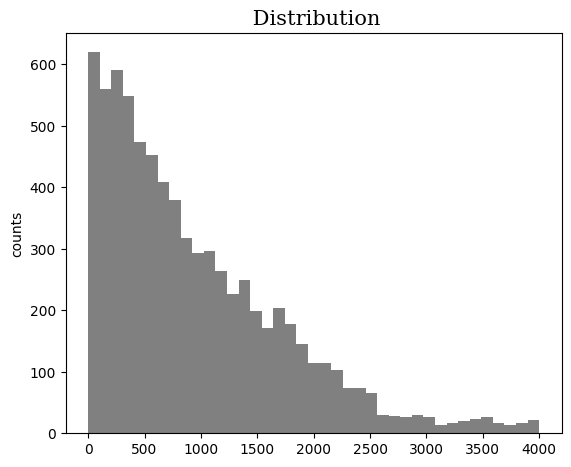

In [47]:
gc_sample.apply_conditions('r3d<4000', inplace=True)
grasp.plots.histogram(gc_sample.r3d.value)

### Density (WOW, bad!)

In [48]:
r3dh = grasp.plots.histogram(gc_sample.r3d.value, dont_show=True)

n_bin = len(r3dh['h']['bins'])

V = np.zeros(n_bin)
rr1 = np.zeros(n_bin+1)
rr2 = np.zeros(n_bin+1)

bw = (gc_sample.r3d.value).max()/n_bin

rr1[0] = 0.
rr2[0] = bw

for x in range (0, n_bin):
  V[x] = (4/3)*np.pi*(rr2[x]**3 - rr1[x]**3)
  rr1[x+1] = rr1[x] + bw
  rr2[x+1] = rr2[x] + bw

rho3D = r3dh['h']['counts']/(V*u.pc**3)  

In [49]:
r_c = (1/gc_sample.gc.px*1000) * np.tan(gc_sample.gc.rc.to(u.rad).value)

In [50]:
plt.plot(gc_sample.gc.model['xi'], gc_sample.gc.model['rho'], '--', c='red', label='SM King Model')
plt.plot(((rr1[0:n_bin]+rr2[0:n_bin])/2)/r_c, rho3D.value, '-o', markersize=2, c='blue', label='Observed Density')
plt.xscale('log')
plt.yscale('log')

### Setting up the velocities

In [51]:
ff.add_formula('Velocity conversion', r"Eq(v_i,r_c*tan(theta))")
ff.velocity_conversion

Eq(v_i, r_c*tan(theta))

In [52]:
gc_sample['pmra'].unit

Unit("mas / yr")

In [53]:
gc_sample.pmra

<Quantity [ 9.92817134,  9.26864011,  9.70835323, ..., 10.10853075,
            9.83702737,  9.98681702] mas / yr>

In [54]:
gc_sample['v_x'] = ((gc_sample.pmra  - gc_sample.gc.pmra ).to(u.rad/u.s) * ((1/gc_sample.gc.px)*u.kpc).to(u.km)) / u.rad 
gc_sample['v_y'] = ((gc_sample.pmdec - gc_sample.gc.pmdec).to(u.rad/u.s) * ((1/gc_sample.gc.px)*u.kpc).to(u.km)) / u.rad

In [55]:
vx_med, vx_med_err = grasp.stats.bootstrap_statistic(gc_sample.v_x.value**2, np.median, n_bootstrap=5000, show_progress=True)
vy_med, vy_med_err = grasp.stats.bootstrap_statistic(gc_sample.v_y.value**2, np.median, n_bootstrap=5000, show_progress=True)

vxm, vxm_err = grasp.stats.bootstrap_statistic(gc_sample.v_x.value**2, np.average, n_bootstrap=5000, show_progress=True)
vym, vym_err = grasp.stats.bootstrap_statistic(gc_sample.v_y.value**2, np.average, n_bootstrap=5000, show_progress=True)


Bootstrap: 100%|██████████| 5000/5000 [00:00<00:00, 90147.35it/s]


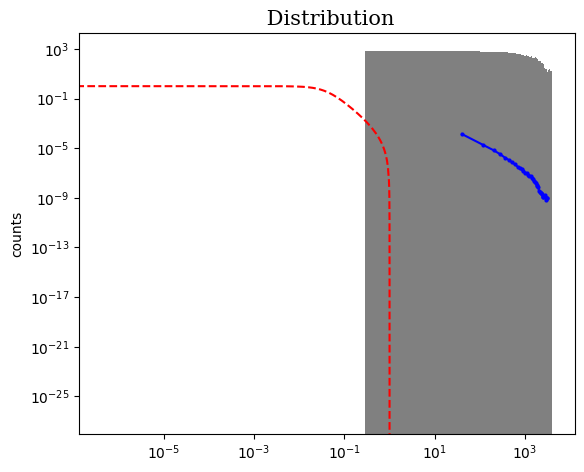

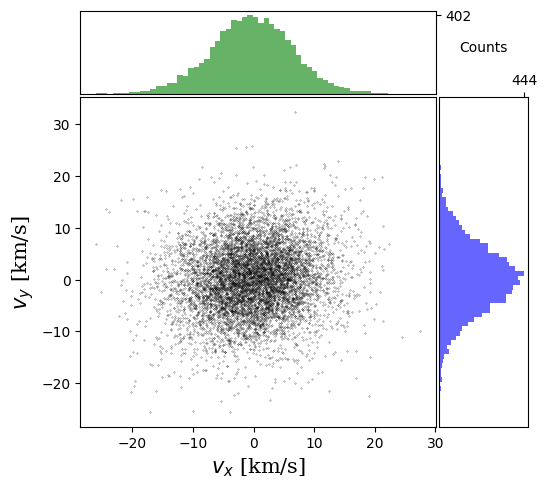

(<Figure size 560x520 with 3 Axes>,
 (<Axes: xlabel='$v_x$ [km/s]', ylabel='$v_y$ [km/s]'>,
  <Axes: >,
  <Axes: xlabel='Counts\n'>))

In [56]:
grasp.plots.doubleHistScatter(gc_sample['v_x'].value, gc_sample['v_y'].value, xlabel=r"$v_x$ [km/s]", ylabel=r'$v_y$ [km/s]',size=0.05, alpha=0.85)

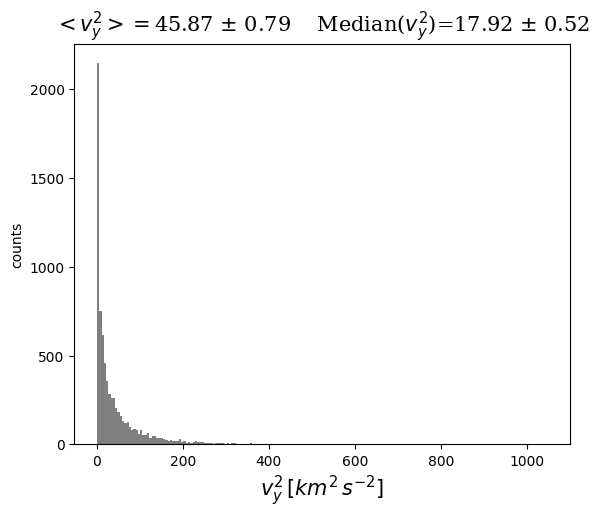

In [57]:
grasp.plots.histogram(
    gc_sample['v_y'].value**2, 
    xlabel=r'$v_y^2 \, [km^2\,s^{-2}]$', title=r'$<v_y^2> = ${:.2f} $\pm$ {:.2f}    Median($v_y^2$)={:.2f} $\pm$ {:.2F}'.format(
        vxm, vym_err,
        vy_med, vy_med_err
        )
    )

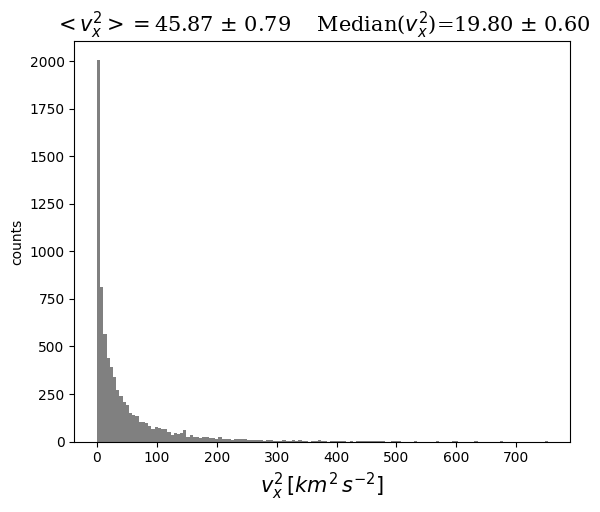

In [58]:
grasp.plots.histogram(
    gc_sample['v_x'].value**2, 
    xlabel=r"$v_x^2 \, [km^2\,s^{-2}]$", title=r'$<v_x^2> = ${:.2f} $\pm$ {:.2f}    Median($v_x^2$)={:.2f} $\pm$ {:.2f}'.format(
        vxm, vxm_err,
        vx_med, vx_med_err
        )
    )

On Isotropy assumption, compute the total (squared) velocity as:

$$ V^2 = \frac{3}{2}(v_x^2 + v_y^2)^2

Bootstrap: 100%|██████████| 5000/5000 [00:00<00:00, 11581.43it/s]


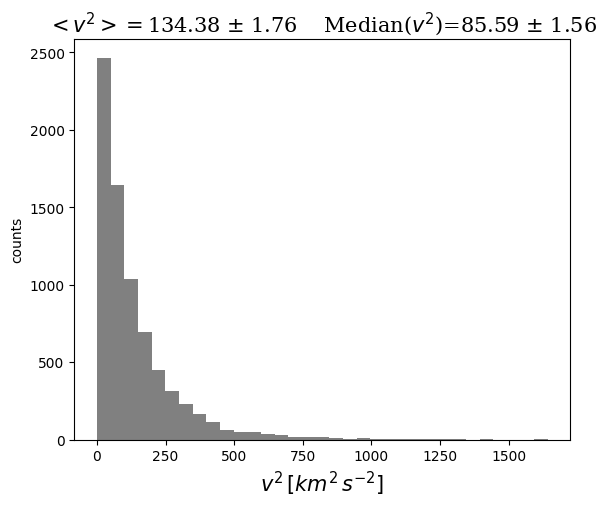

In [59]:
gc_sample['v2'] = 1.5*(gc_sample['v_x']**2 + gc_sample['v_y']**2) 
v2m, v2m_err = grasp.stats.bootstrap_statistic(gc_sample.v2.value, np.average, n_bootstrap=5000, show_progress=True)
v2_med, v2_med_err = grasp.stats.bootstrap_statistic(gc_sample.v2.value, np.median, n_bootstrap=5000, show_progress=True)
v2h = grasp.plots.histogram(
    gc_sample['v2'].value, 
    xlabel=r"$v^2 \, [km^2\,s^{-2}]$", title=r'$<v^2> = ${:.2f} $\pm$ {:.2f}    Median($v^2$)={:.2f} $\pm$ {:.2f}'.format(
        v2m, v2m_err,
        v2_med, v2_med_err
        ),
    out=True
    )

### Shell Partition

In [94]:
# Desired number of instances per subsample
n_per_shell = 100  # for example

# Sort by r3d
sorted_sample = gc_sample.to_pandas().sort_values('r3d')

# Split into equal-length subsamples
shell_samples = [
    sorted_sample.iloc[i:i + n_per_shell]
    for i in range(0, len(sorted_sample), n_per_shell)
]

# Optionally, filter out the last shell if it's too small
shell_samples = [s for s in shell_samples if len(s) == n_per_shell]

In [95]:
v2 = grasp.types.QTable()
R  = grasp.types.QTable()

for i,shell in enumerate(shell_samples):
    
    R[f"s{i}"] = shell['r3d']
    v2[f"s{i}"] = shell['v2']

v2 = grasp.Sample(v2, gc)
R = grasp.Sample(R, gc)

In [96]:
v2h = []
for i in range(len(shell_samples)):
    v2h.append(grasp.plots.histogram(v2[f's{i}'], xlabel='$v^2$', title=f'Shell {i} - R_max={R[f"s{i}"].max():.3f} - R_width = {R[f"s{i}"].max() - R[f"s{i}"].min():.3f}', dont_show=True))

### $B = 16 A \sqrt{2} \pi^2 \beta^2 r_{s}^2 \alpha m^3 \sigma^3 dr dx$

#### Constants:

> Normalization constant: $A = 1$

> Single star Mass: $m = 1$

> Incompleteness parameter: $\alpha = 10^{-3}$


In [97]:
A = 1.
alpha = .001
m = 1.

ff.substitute('B constant', 
              {
                  'A': A,
                  'alpha': alpha,
                  'm': m
              }
)

Eq(B, 0.016*sqrt(2)*beta**2*dr*dx*pi**2*r_{s}**2*sigma**3)


In [98]:
ff.b_constant

Eq(B, 0.016*sqrt(2)*beta**2*dr*dx*pi**2*r_{s}**2*sigma**3)

#### $\sigma^2$ : critical velocity 

It is taken to be the maximum quadratic velocity of the shell $v^2\{shell\}^{max}$. <br>
It's the memory of the Maxwellian velocity distribution of the system.

In [99]:
sigmas = []
for i,s in enumerate(shell_samples):
    sigmas.append(np.sqrt(s.v2.max()))

sigmas = np.array(sigmas)

In [100]:
plt.plot(sigmas, '--o', markersize=3, c='blue')

#### $\beta$ & $r_s$
 $\beta$ : Estimation from bootstrap statistics on shell<br>
Its the uncertainty parameter on the distance of the shell from the centre of the GC. <br>
This parameter could be estimated by computing the uncertainty of the median <br>
(not the mean, as outliers could heavily affect the result) of the $R_{3D}$ distances of <br>
the stars of the shell from the centre

$r_s$ : Median distance from the centre

In [101]:
betas = []
rss = []

for i, s in enumerate(shell_samples):
    r, b = grasp.stats.bootstrap_statistic(
        s['r3d'],
        np.median,
        n_bootstrap=100,
        show_progress=False
    )
    betas.append(b)
    rss.append(r)

    
betas = np.array(betas)
rss = np.array(rss)

In [102]:
plt.plot(rss, betas, '--o', markersize=3, c='blue')

#### $N$ , $x$

In [103]:
Ns = []
x = []

for i, v in enumerate(v2h):
    Ns.append(v['h']['counts'])
    x.append(v['h']['bins']/(2*sigmas[i]**2))


#### $dx$ and $dr$

In [104]:
dr = []
dx = []

for i, s in enumerate(shell_samples):
    dr.append(s.r3d.max() - s.r3d.min())
    dx.append(v2h[i]['h']['bins'][1] - v2h[i]['h']['bins'][0])

### $\Sigma = \ln{B} - x - \ln{\frac{\Delta_N}{\sqrt{x}}}$

In [105]:
def Sigma(
    B: float,
    n: int = None,
    fit: grasp.types.Optional[grasp.types.RegressionModels] = None
) -> tuple[grasp.types.ArrayLike, grasp.types.ArrayLike]:
    """Computes analythical sigma"""
    xi = np.linspace(0, 0.5, 1000)
    if fit:
        #xi = np.linspace(0, 0.5, len(fit.x))
        A, l = fit.coeffs
        n = A* np.exp(l * xi)
    elif n is None:
        raise ValueError("Either n or alpha must be provided.")
    return (xi, np.log(B) - np.log(n / xi**0.5) - xi)

In [106]:
import grasp.analyzers
import grasp.analyzers.calculus

poteffs = []
Bs = []

for i in range(len(shell_samples)):
    B = float(grasp.analyzers.calculus._sp.N(ff.b_constant.rhs.subs(
        {
            'r_{s}': rss[i],
            'sigma': sigmas[i],
            'dr': dr[i],
            'dx': dx[i],
            'beta' : betas[i],
            'pi': np.pi
        }
    )))
    Bs.append(B)
    poteffs.append(
        np.log(B) - x[i] - np.log(Ns[i] / x[i]**0.5)
    )


/tmp/ipykernel_113879/2741801785.py:20: RuntimeWarning: divide by zero encountered in log
  np.log(B) - x[i] - np.log(Ns[i] / x[i]**0.5)


In [107]:
def plot_poteff(n_shell: int):
    """Plot the effective potential for a given shell or list of shells."""
    fit = grasp.stats.fit_data_points(Ns[n_shell], x_data=x[n_shell], method='exponential')

    fig, ax = plt.subplots(figsize=(8,6.5))
    ax.plot(x[n_shell], poteffs[n_shell], 'o', markersize=4, c='black')
    xi, S = Sigma(Bs[n_shell], fit=fit)
    ax.plot(xi, S, '-', markersize=3, c='red')
    ax.set_ylabel(r'$\Phi_{eff}$', fontdict=grasp.plots.label_font)
    ax.set_xlabel(r'$x$', fontdict=grasp.plots.label_font)
    ax.set_title(f'Shell {n_shell} at ~{rss[n_shell]:.3f} pc', fontdict=grasp.plots.title_font)
    ax.set_xlim((-0.01, 0.51))

    return fig

folder = grasp.gpaths.CLUSTER_DATA_FOLDER(gc_sample.gc.id) + '/poteff_plots'
if not os.path.exists(folder):
    os.makedirs(folder)
for i in range(len(shell_samples)):
    fig = plot_poteff(i)
    fig.savefig(f'{folder}/poteff_shell_{i}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)



/tmp/ipykernel_113879/3036955819.py:14: RuntimeWarning: divide by zero encountered in divide
  return (xi, np.log(B) - np.log(n / xi**0.5) - xi)


In [108]:
scarti_finali = []
for i in range(len(poteffs)):
    fit = grasp.stats.fit_data_points(Ns[i], x_data=x[i], method='exponential')
    xi, S = Sigma(Bs[i], fit=fit)

    scarti_finali.append(1-poteffs[i][-1]/S[-1])

scarti_finali = np.array(scarti_finali)

avg_underestimation = grasp.stats.bootstrap_statistic(scarti_finali, np.mean)
fig = plt.figure()
plt.plot(scarti_finali, 'o', markersize=3, c='blue')
plt.xlabel('Shell number', fontdict=grasp.plots.label_font)
plt.title(f"Average Underestimation = {avg_underestimation[0]*100 :.2f} +- {avg_underestimation[1]*100:.2f} %")
# fig.savefig(
#     grasp.gpaths.CLUSTER_DATA_FOLDER(gc_sample.gc.id) + '/poteff_plots/model2/scarti_finali.png',
#     dpi=300, bbox_inches='tight'
# )

/tmp/ipykernel_113879/3036955819.py:14: RuntimeWarning: divide by zero encountered in divide
  return (xi, np.log(B) - np.log(n / xi**0.5) - xi)
Bootstrap: 100%|██████████| 1000/1000 [00:00<00:00, 288724.72it/s]


Text(0.5, 1.0, 'Average Underestimation = 11.93 +- 0.73 %')

In [109]:
avg_underestimation = grasp.stats.bootstrap_statistic(scarti_finali, np.mean)

print(f"{avg_underestimation[0]*100 :.2f} +- {avg_underestimation[1]*100:.2f} %")

Bootstrap: 100%|██████████| 1000/1000 [00:00<00:00, 175186.03it/s]

11.93 +- 0.73 %


The average underestimation of the critical velocioty $x=0.5 \rightarrow \sigma^2 = 2\cdot v^2_{max}$ 
is 
> $15,94 \pm  0,98$ %

### $\Sigma = -\ln{1-e^{x-w}}$